In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from neo import io
import pandas as pd
from hmmlearn import hmm

# Load data

In [3]:
r = io.IgorIO(filename='upShots_3623.ibw')
data_an_up = r.read_analogsignal()
data_arr_up = np.array(data_an_up)

r = io.IgorIO(filename='downShots_3624.ibw')
data_an_down = r.read_analogsignal()
data_arr_down = np.array(data_an_down)
data_arr_up.shape

(9992, 5000)

# Setting up functions

In [4]:
def process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind):
    
    # x_0 and x_N should be entered with the same nr of sigfigs, and b_x 
    # should be smaller than the last decimal in x_0 and x_N
    
    len_counts = int((x_N - x_0)/b_x)
    print(len_counts)
    
    processed_up_all = []
    processed_down_all = []
    
    for i in range(data_start_index, data_stop_index):
        data_up_raw = np.array(data_arr_up[:,i])[15:T_ind]
        data_down_raw = np.array(data_arr_down[:,i])[15:T_ind]
        
        temp_up = (data_up_raw - np.ones(len(data_up_raw))*x_0)/(np.ones(len(data_up_raw))*b_x)
        temp_up = (np.rint(temp_up)).astype(int)
        
        temp_down = (data_down_raw - np.ones(len(data_down_raw))*x_0)/(np.ones(len(data_down_raw))*b_x)
        temp_down = (np.rint(temp_down)).astype(int)
        
        processed_up_all.append(temp_up)
        processed_down_all.append(temp_down)
        
    return processed_up_all, processed_down_all

def find_B(x_occ, x_unocc, sig, b_x, x_0, x_N):
    
    num = int((x_N - x_0)/b_x)
    
    x = np.linspace(x_0, x_N, num)
            
    b_est_occ = np.exp(- ((x - np.ones_like(x)*x_occ)**2) / (np.ones_like(x)*(sig**2)*2) )
    b_est_unocc = np.exp(- ((x - np.ones_like(x)*x_unocc)**2) / (np.ones_like(x)*(sig**2)*2) )
    
    b_est_occ = b_est_occ/sum(b_est_occ)
    b_est_unocc = b_est_unocc/sum(b_est_unocc)
    
    B = np.array([b_est_occ, b_est_unocc])
    
    return B

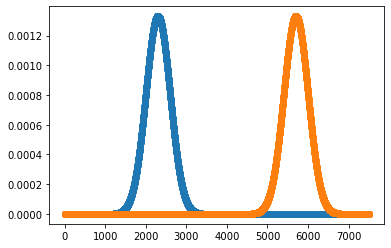

In [5]:
B = find_B(0.03, 0.37, 0.03, 0.0001, -0.2, 0.55)

plt.scatter(np.array(range(len(B[0]))), B[0])
plt.scatter(np.array(range(len(B[1]))), B[1])

In [6]:
def test(A, B, pi, test_start_index, test_stop_index, test_data_up, test_data_down):
    
    # new model
    model = hmm.CategoricalHMM(n_components=2)
    model.transmat_ = A
    model.emissionprob_ = B
    model.startprob_ = pi

    test_window = (test_stop_index - test_start_index)

    # new
    corru = 0
    wrongu = 0

    corrd = 0
    wrongd = 0

    wrong_ind_up = []
    wrong_ind_down = []
    
    # old
    corru_p = 0
    wrongu_p = 0

    corrd_p = 0
    wrongd_p = 0

    p_wrong_ind_u = []
    p_wrong_ind_d = []

    for i in range(len(test_data_up)):
        res_up_temp = model.predict(np.array(test_data_up[i]).reshape(1,-1))
        res_down_temp = model.predict(np.array(test_data_down[i]).reshape(1,-1))

        # new
        if sum(res_up_temp) >= 1:
            corru += 1
        else:
            wrongu += 1
            wrong_ind_up.append(i)

        if sum(res_down_temp) < 1:
            corrd += 1
        else:
            wrongd += 1
            wrong_ind_down.append(i)
        
        # old
        if max(test_data_up[i]) > (47/75)*(x_N-x_0)/b_x:
            res_up_temp = 0
        else:
            res_up_temp = 1

        if max(test_data_down[i]) > (47/75)*(x_N-x_0)/b_x:
            res_down_temp = 0
        else:
            res_down_temp = 1

        if res_up_temp == 0: # if above 470
            corru_p += 1
        else:
            wrongu_p += 1
            p_wrong_ind_u.append(i)

        if res_down_temp == 1: # if not above 470
            corrd_p += 1
        else:
            wrongd_p += 1
            p_wrong_ind_d.append(i)
            
    # new model metrics
    acc_rate_up = corru/(test_window)
    acc_rate_down = corrd/(test_window)
    
    #old mode metrics
    p_acc_rate_up = corru_p/(test_window)
    p_acc_rate_down = corrd_p/(test_window)
    
    return acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down

# Tune hyperparams

In [61]:
data_start_index = 0
data_stop_index = 1000
x_0 = -0.2
x_N = 0.55
x_occ = 0.03
x_unocc = 0.37
sig = 0.03


In [62]:
b_x = 0.01
T_ind = 800

A_init = np.array([[0.95, 0.05],[0.10, 0.90]])
pi_init = np.array([1, 0])
B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)

mid = int((x_N - x_0)/(2*b_x))

train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='s' )
model.transmat_ = A_init
model.emissionprob_ = B_init

75


In [63]:
model.fit(train_up_set_processed, (len(train_up_set_processed),))

CategoricalHMM(init_params='s', n_components=2,
               random_state=RandomState(MT19937) at 0x7FD969298540)

In [64]:
A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[1][0:mid]):
    B = np.array([B[0],B[1]])
    

Text(0, 0.5, 'prob of obs')

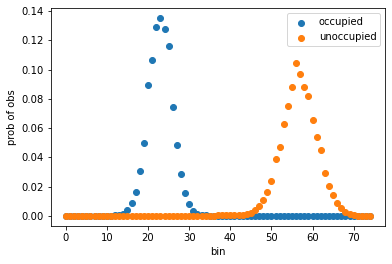

In [65]:
plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

In [66]:
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

In [67]:
print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

b_x is 0.01
T is 314.0
Up acc new:  0.98  acc old:  0.98
Down acc new:  1.0  acc old:  1.0


150
b_x is 0.005
T is 314.0
Up acc new:  0.98  acc old:  0.98
Down acc new:  1.0  acc old:  1.0


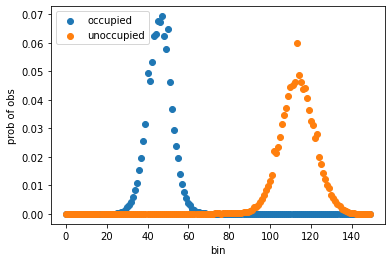

In [68]:
b_x = 0.005
T_ind = 800

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
b_x is 0.001
T is 314.0
Up acc new:  0.98  acc old:  0.981
Down acc new:  0.996  acc old:  1.0


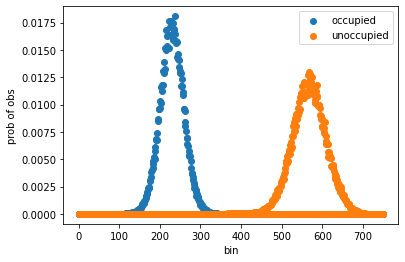

In [92]:
b_x = 0.001
T_ind = 800

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
b_x is 0.0005
T is 314.0
Up acc new:  0.98  acc old:  0.981
Down acc new:  0.996  acc old:  1.0


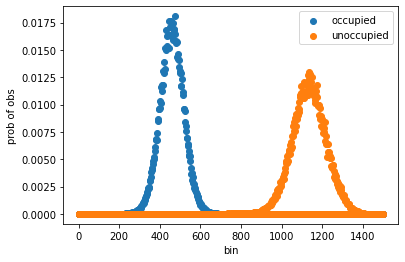

In [70]:
b_x = 0.0005
T_ind = 800

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)

train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[1][0:mid]):
    B = np.array([B[0],B[1]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
b_x is 1e-05
T is 314.0
Up acc new:  0.98  acc old:  0.981
Down acc new:  0.996  acc old:  1.0


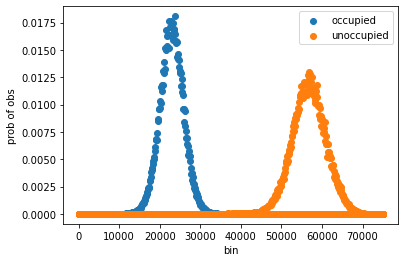

In [71]:
b_x = 0.00001
T_ind = 800

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[1][0:mid]):
    B = np.array([B[0],B[1]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
b_x is 0.01
T is 594.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999


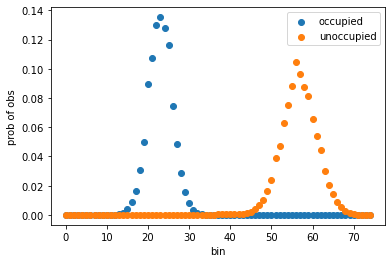

In [72]:
b_x = 0.01
T_ind = 1500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
b_x is 0.005
T is 594.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999


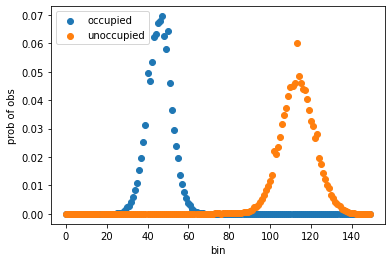

In [73]:
b_x = 0.005
T_ind = 1500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
b_x is 0.001
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.997  acc old:  0.999


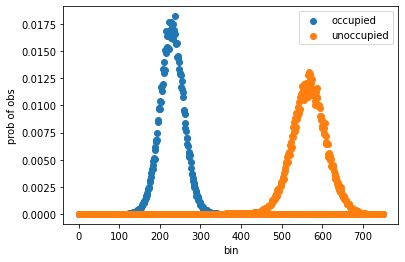

In [74]:
b_x = 0.001
T_ind = 1500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
b_x is 0.0005
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.997  acc old:  0.999


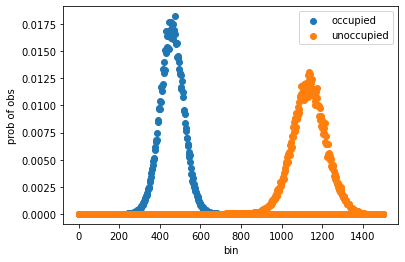

In [75]:
b_x = 0.0005
T_ind = 1500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
b_x is 1e-05
T is 594.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.997  acc old:  0.999


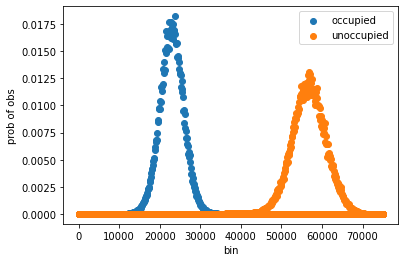

In [76]:
b_x = 0.00001
T_ind = 1500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75
b_x is 0.01
T is 674.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999


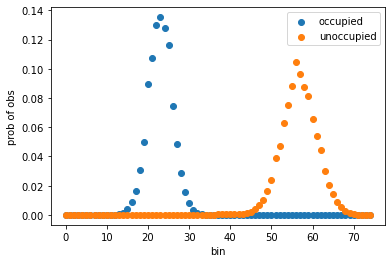

In [77]:
b_x = 0.01
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

150
b_x is 0.005
T is 674.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999


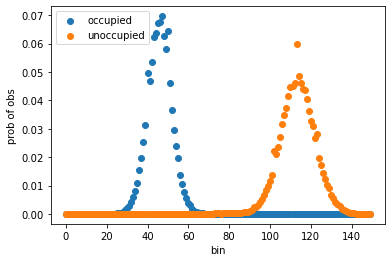

In [78]:
b_x = 0.005
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

750
b_x is 0.001
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999


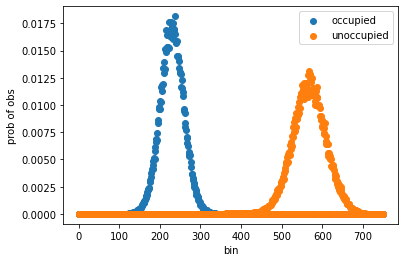

In [79]:
b_x = 0.001
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

1500
b_x is 0.0005
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999


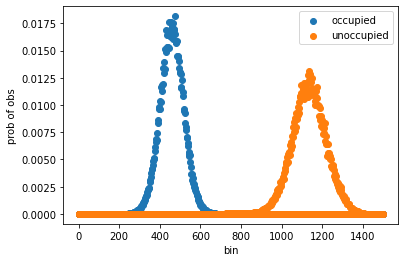

In [80]:
b_x = 0.0005
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

75000
b_x is 1e-05
T is 674.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999


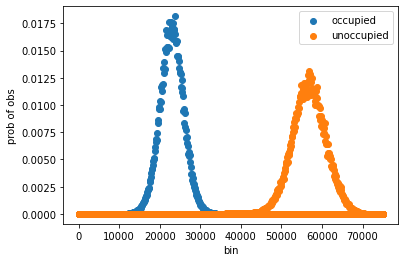

In [81]:
b_x = 0.00001
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)

In [93]:
(0.989+0.998)/2

0.9935

75
b_x is 0.01
T is 754.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.999  acc old:  0.999
Avg is  0.994


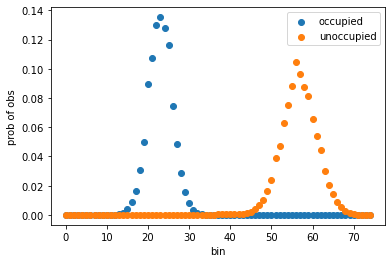

In [82]:
b_x = 0.01
T_ind = 1900

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

150
b_x is 0.005
T is 754.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999
Avg is  0.9935


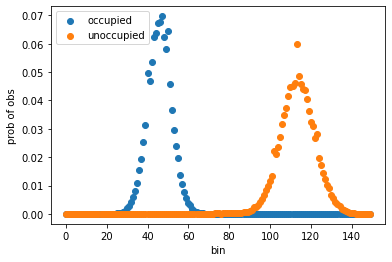

In [83]:
b_x = 0.005
T_ind = 1900

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

750
b_x is 0.001
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999
Avg is  0.9935


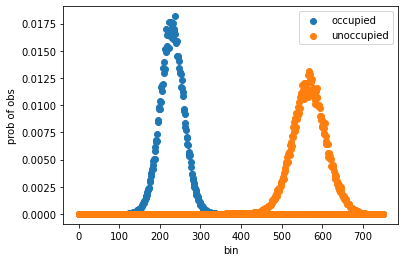

In [84]:
b_x = 0.001
T_ind = 1900

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

1500
b_x is 0.0005
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999
Avg is  0.9935


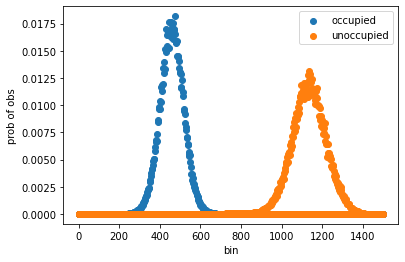

In [85]:
b_x = 0.0005
T_ind = 1900

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

75000
b_x is 1e-05
T is 754.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.998  acc old:  0.999
Avg is  0.9935


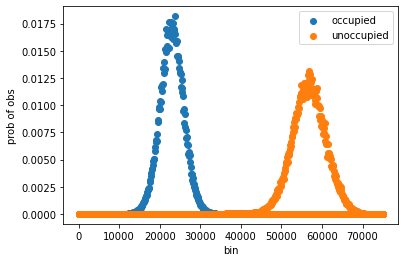

In [86]:
b_x = 0.00001
T_ind = 1900

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

75
b_x is 0.01
T is 994.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.999  acc old:  0.999
Avg is  0.994


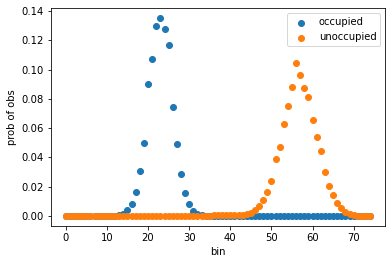

In [87]:
b_x = 0.01
T_ind = 2500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

150
b_x is 0.005
T is 994.0
Up acc new:  0.989  acc old:  0.989
Down acc new:  0.998  acc old:  0.999
Avg is  0.9935


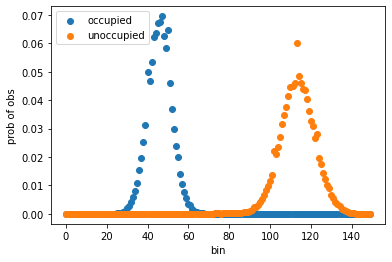

In [88]:
b_x = 0.005
T_ind = 2500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

750
b_x is 0.001
T is 994.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.996  acc old:  0.999
Avg is  0.9924999999999999


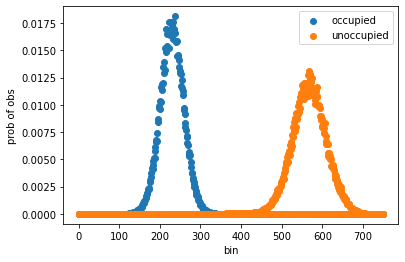

In [89]:
b_x = 0.001
T_ind = 2500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

1500
b_x is 0.0005
T is 994.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.996  acc old:  0.999
Avg is  0.9924999999999999


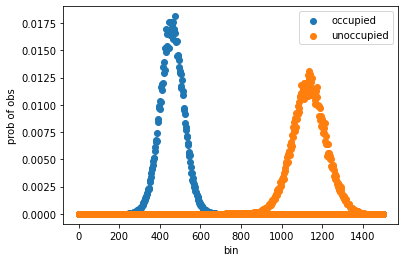

In [90]:
b_x = 0.0005
T_ind = 2500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

75000
b_x is 1e-05
T is 994.0
Up acc new:  0.989  acc old:  0.99
Down acc new:  0.996  acc old:  0.999
Avg is  0.9924999999999999


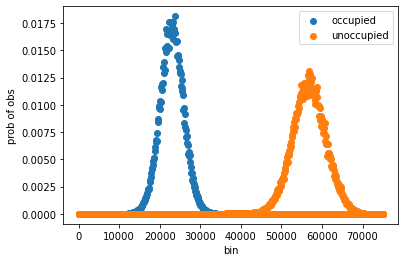

In [91]:
b_x = 0.00001
T_ind = 2500

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features=B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

# Train model

In [94]:
data_start_index = 1000
data_stop_index = 4000
x_0 = -0.2
x_N = 0.55
x_occ = 0.03
x_unocc = 0.37
sig = 0.03

75
b_x is 0.01
T is 674.0
Up acc new:  0.9896666666666667  acc old:  0.9906666666666667
Down acc new:  0.9963333333333333  acc old:  0.9963333333333333
Avg is  0.993


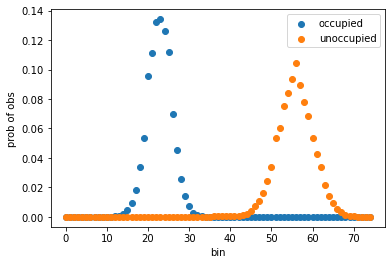

In [95]:
b_x = 0.01
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index, data_stop_index, train_up_set_processed, train_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

# Benchmarking 1

In [96]:
up, down = process_data(4000, 5000, b_x, x_0, x_N, T_ind)

acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, 4000, 5000, up, down)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

75
b_x is 0.01
T is 674.0
Up acc new:  0.986  acc old:  0.987
Down acc new:  0.997  acc old:  0.997
Avg is  0.9915


# Manual rotations

## Rotation 1

In [7]:
data_start_index = 1000
data_stop_index = 4000
data_start_index_test = 4000
data_stop_index_test = 5000

75
75
b_x is 0.01
T is 674.0
Up acc new:  0.987  acc old:  0.987
Down acc new:  0.997  acc old:  0.997
Avg is  0.992


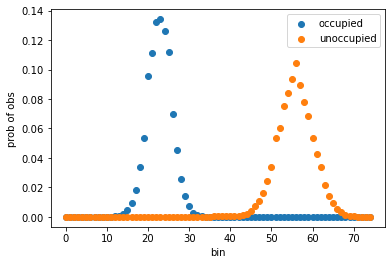

In [9]:
b_x = 0.01
T_ind = 1700

x_0 = -0.2
x_N = 0.55
x_occ = 0.03
x_unocc = 0.37
sig = 0.03

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])
    A = np.array([A[1],A[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

test_up_set_processed, test_down_set_processed = process_data(data_start_index_test, data_stop_index_test, b_x, x_0, x_N, T_ind)
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index_test, data_stop_index_test, test_up_set_processed, test_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

## Rotation 2 

In [10]:
data_start_index = 2000
data_stop_index = 5000
data_start_index_test = 1000
data_stop_index_test = 2000

75
75
b_x is 0.01
T is 674.0
Up acc new:  0.994  acc old:  0.992
Down acc new:  0.994  acc old:  0.994
Avg is  0.994


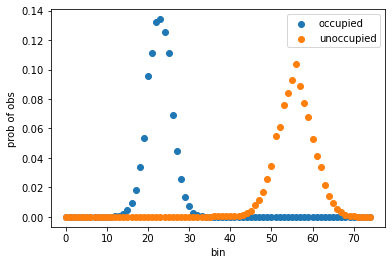

In [11]:
b_x = 0.01
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])
    A = np.array([A[1],A[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

test_up_set_processed, test_down_set_processed = process_data(data_start_index_test, data_stop_index_test, b_x, x_0, x_N, T_ind)
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index_test, data_stop_index_test, test_up_set_processed, test_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

## Rotation 3

In [12]:
data_start_index = 3000
data_stop_index = 5000
data_start_index1 = 1000
data_stop_index1 = 2000

data_start_index_test = 2000
data_stop_index_test = 3000

75
75
75
b_x is 0.01
T is 674.0
Up acc new:  0.992  acc old:  0.99
Down acc new:  0.995  acc old:  0.996
Avg is  0.9935


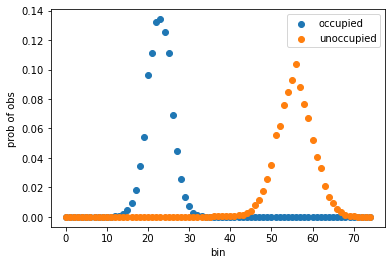

In [13]:
b_x = 0.01
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
train_up_set_processed1, train_down_set_processed1 = process_data(data_start_index1, data_stop_index1, b_x, x_0, x_N, T_ind)

train_up_set_processed_full = np.concatenate((train_up_set_processed, train_up_set_processed1))

model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])
    A = np.array([A[1],A[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

test_up_set_processed, test_down_set_processed = process_data(data_start_index_test, data_stop_index_test, b_x, x_0, x_N, T_ind)
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index_test, data_stop_index_test, test_up_set_processed, test_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)

## Rotation 4

In [15]:
data_start_index = 4000
data_stop_index = 5000
data_start_index1 = 1000
data_stop_index1 = 3000

data_start_index_test = 3000
data_stop_index_test = 4000

75
75
75
b_x is 0.01
T is 674.0
Up acc new:  0.99  acc old:  0.99
Down acc new:  0.998  acc old:  0.999
Avg is  0.994


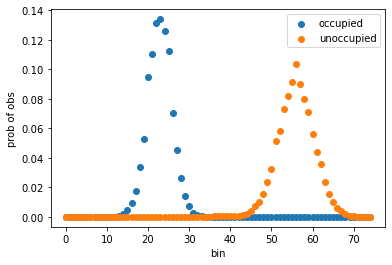

In [16]:
b_x = 0.01
T_ind = 1700

mid = int((x_N - x_0)/(2*b_x))

B_init = find_B(x_occ, x_unocc, sig, b_x, x_0, x_N)
train_up_set_processed, train_down_set_processed = process_data(data_start_index, data_stop_index, b_x, x_0, x_N, T_ind)
train_up_set_processed1, train_down_set_processed1 = process_data(data_start_index1, data_stop_index1, b_x, x_0, x_N, T_ind)

train_up_set_processed_full = np.concatenate((train_up_set_processed, train_up_set_processed1))

model = hmm.CategoricalHMM(n_components=2, init_params='')
model.n_features = B_init.shape[1]
model.transmat_ = np.array([[0.95, 0.05],[0.10, 0.90]])
model.emissionprob_ = B_init
model.startprob_ = np.array([1, 0])

model.fit(train_up_set_processed, (len(train_up_set_processed),))

A = model.transmat_
B = model.emissionprob_
pi = model.startprob_

if sum(B[0][0:mid]) < sum(B[0][mid:-1]):
    B = np.array([B[1],B[0]])
    A = np.array([A[1],A[0]])

plt.scatter(range(len(B[0])), B[0], label='occupied')
plt.scatter(range(len(B[1])), B[1], label='unoccupied')
plt.legend()
plt.xlabel('bin')
plt.ylabel('prob of obs')

test_up_set_processed, test_down_set_processed = process_data(data_start_index_test, data_stop_index_test, b_x, x_0, x_N, T_ind)
acc_rate_up, acc_rate_down, p_acc_rate_up, p_acc_rate_down = test(A, B, pi, data_start_index_test, data_stop_index_test, test_up_set_processed, test_down_set_processed)

print('b_x is', b_x)
print('T is', (T_ind-15)*1e6/(2.5e6))
print('Up acc new: ', acc_rate_up, ' acc old: ', p_acc_rate_up)
print('Down acc new: ', acc_rate_down, ' acc old: ', p_acc_rate_down)
print('Avg is ', (acc_rate_up + acc_rate_down)/2)